In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
from sklearn import decomposition

from sklearn import preprocessing, decomposition, model_selection, linear_model, metrics, ensemble, svm, utils
from sklearn.datasets import make_classification
from sklearn import preprocessing

In [4]:
# Get the data
train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')
test_transaction = pd.read_csv('../data/test_transaction.csv')
test_identity = pd.read_csv('../data/test_identity.csv')

In [5]:
# Join datasets
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(f'Shape of train set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of train set: (590540, 435)
Shape of test set: (506691, 434)


In [6]:
# Reduce memory usage
def reduce_mem(df):
  start_mem=df.memory_usage().sum()/1024**2
  print('Initial Memory Usage : {:.2f} MB'.format(start_mem))
  for col in df.columns:
    col_type=df[col].dtype
    if col_type != object:
      mn, mx = df[col].min(), df[col].max()
      if str(col_type)[:3]=='int':
        if mn>np.iinfo(np.int8).min and mx<np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif mn>np.iinfo(np.int16).min and mx<np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif mn>np.iinfo(np.int32).min and mx<np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
      else:
        if mn>np.finfo(np.float16).min and mx<np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif mn>np.finfo(np.float32).min and mx<np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
  end_mem = df.memory_usage().sum()/1024**2
  print('Final Memory Usage : {:.2f} MB'.format(end_mem))
  print('Decreased by {:.2f}%'.format(100*(start_mem-end_mem)/start_mem))
  return df

In [7]:
train = reduce_mem(train)
test = reduce_mem(test)

Initial Memory Usage : 1959.88 MB
Final Memory Usage : 648.22 MB
Decreased by 66.93%
Initial Memory Usage : 1677.73 MB
Final Memory Usage : 563.43 MB
Decreased by 66.42%


In [ ]:
import gc
del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

Text(0.5, 1.0, 'Target distribution')

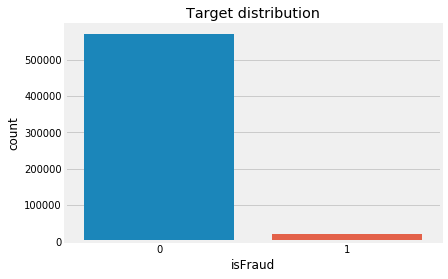

In [8]:
sns.countplot(train['isFraud']) #Imbalanced Dataset
plt.title('Target distribution')

In [9]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

print(len(not_fraud))
print(len(fraud))

# Downsample the data and re-concatenate
not_fraud_downsampled = utils.resample(not_fraud, replace=False, n_samples = len(fraud), random_state = 27) 
train = pd.concat([not_fraud_downsampled, fraud])

569877
20663


In [10]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

print(len(not_fraud))
print(len(fraud))

20663
20663


In [11]:
y = train.isFraud.values

train = train.drop('isFraud', axis=1)
test = test.copy()

# Delete rows with more than 70%? of NaNs, and fill out the rest with some value
train = train.fillna(-1)
test = test.fillna(-1) 

In [12]:

# Label Encoding
for f in train.columns:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values)) 

In [13]:
scaler = preprocessing.StandardScaler() # MinMaxScaler StandardScaler RobustScaler
cols = list(train.columns)
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

KeyError: "['isFraud'] not found in axis"

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

N = 50

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# svd_param_grid = {'n_components':[25, 50, 100, 200], 'n_iters':[5, 10, 15, 20]}
svd = decomposition.TruncatedSVD(n_components=N)
# svd_gs = GridSearchCV(svd, svd_param_grid, cv=10)
# svd_gs.fit(train[cols], y, scoring=scoring)
# sorted(svd_gs.cv_results_.keys())

X = svd.fit_transform(train[cols], y) 
# svd.explained_variance_ratio_.sum()

In [33]:
df = pd.DataFrame()
df["isFraud"] = y

for i in range(50):
    df[i] = X[:,i]
    
df.tail()

,isFraud,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
41321,1,-7.274425,-2.435000,0.644038,2.809027,0.635110,-1.750348,-0.015046,-1.261421,-1.434899,...,0.426970,0.319744,0.441345,-0.863203,0.749934,-0.607932,0.581192,-1.386665,1.103033,0.317488
41322,1,2.320719,10.553612,-0.071569,1.518252,-2.990253,3.221770,0.319778,0.119557,-0.249551,...,-0.451432,0.553322,-0.320686,0.433284,0.569041,-0.326525,0.333149,-0.116997,0.689549,-0.084980
41323,1,11.627551,-9.554355,-4.780430,4.122656,-3.484966,-0.330620,0.287769,0.697399,2.843373,...,-0.134567,-0.210030,0.627275,0.932135,0.231212,-0.153682,0.895302,-1.615529,-0.445934,-0.009375
41324,1,-6.883870,-2.133172,0.550681,2.688653,0.277458,-1.189489,-0.036238,-1.069722,-1.321542,...,-0.065555,0.308651,0.389117,-0.610729,0.573023,-0.402664,1.321454,0.432981,0.022009,0.035779
41325,1,11.483973,-9.625252,-4.794011,4.128292,-3.416042,-0.399654,0.256340,0.662800,2.817887,...,1.723719,0.453415,0.190239,0.350358,0.700027,-0.321788,1.012605,-1.666173,-0.610839,-0.295990


In [34]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop('isFraud',axis=1), y, test_size=.2, random_state=1)

In [41]:
%%time

skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "reg"

lr_param_grid = {}
rfc_param_grid = {'n_estimators':[25, 50, 100], 'criterion':('gini', 'entropy')}
svc_param_grid = {}

#reg = linear_model.LogisticRegression(C=1, solver="newton-cg", penalty="l2", n_jobs=-1, max_iter=200).fit(X_train, y_train) 
# rfc = ensemble.RandomForestClassifier(n_estimators=200,criterion='gini',n_jobs=-1).fit(X_train, y_train)
rfc = ensemble.RandomForestClassifier()
rfc_gs = GridSearchCV(rfc, rfc_param_grid, cv=10)
rfc_gs.fit(X_train, y_train)
#reg = svm.SVC(max_iter=200).fit(X_train, y_train)
# try gaussianNB()

y_pred = rfc.predict_proba(X_test)
print(y_test)
print(y_pred)
print(metrics.classification_report(y_test, [round(y[1]) for y in y_pred]))
sorted(rfc_gs.cv_results_.keys())

KeyboardInterrupt: 

In [ ]:
svc_param_grid = {C:[1, 10, 100], kernel:}